### UChicago MSFM Project Lab (2023 Spring) with MSUSA

# Time scaling of rating transition matrix (Demo from CPM desk 4/13/2023)

## Referenced papers

- *Kreinin, A., & Sidelnikova, M. (2001). Regularization algorithms for transition matrices. Algo Research Quarterly, 4(1/2), 23-40.*
- *Inamura, Y. (2006). Estimating continuous time transition matrices from discretely observed data. Bank of Japan, (06-E07).*

### Imports

In [1]:
import time as tm
import datetime as dtm
import random as rd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as lg
from scipy.stats import gamma

from functools import partial

In [2]:
print('>>> the version of pandas package...')
print(pd.__version__)

>>> the version of pandas package...
0.23.4


### Constants

In [3]:
# constants
num_week = 52
dic_scn = {'sp_raw': 'S&P raw',
           'sp_adj': 'S&P adj',
           'mdy_raw': "Moody's raw",
           'mdy_adj': "Moody's adj",
           'test': 'Hypothetical Test',
           }
# constants for visualization
size_figm = (6,5)  #(6,4)
size_figl = (13,5) #(13,4)
size_fntl = 12.0
widh_lin = 0.2
cmap_trg1 = 'YlGnBu'
cmap_trg2 = 'pink'
cmap_trg3 = 'vlag'
cmap_trg4 = 'PuOr'
# 'Paired', 'Accent', 'CMRmap', 'CMRmap_r', 'brg_r', 'gnuplot', 'plasma', 'YlOrBr', 'Reds', 'PuRd', 'PuOr', autumn', 'Spectral'
cmaps_trg = (cmap_trg1,cmap_trg2)
# figure parameters
val_cmin = 0.00
val_cmax = 0.95
val_cneg = -5.0e-5
# titles
subtitle1 = 'Probability Heatmap'
subtitle2 = 'Negative Probability Grid'
subtitle3 = 'Real Part of the Matrix'
subtitle4 = 'Imaginary Part of the Matrix'

## 1. Preparation

### 1.2. Helper Functions

In [4]:
# Helper function
# ######################################################################
def heatmap_matrix(mtx,vmin,vmax,cmap=cmap_trg1,header=None):
    fig, ax = plt.subplots(figsize=size_figm)
    sns.heatmap(mtx,linewidth=widh_lin,cmap=cmap,vmin=vmin,vmax=vmax,ax=ax)
    if header is not None:
        fig.suptitle(header,fontsize=size_fntl,x=0.46,y=0.96)
    plt.show()

def multi_heatmap_matrix(mtx,vmins,vmaxs,cmaps,header=None,submtx=np.nan,sub1=subtitle1,sub2=subtitle2):
    try:
        submtx.empty
    except:
        submtx = mtx.copy()
    fig, ax = plt.subplots(1,2,figsize=size_figl)
    sns.heatmap(mtx,linewidth=widh_lin,cmap=cmaps[0],vmin=vmins[0],vmax=vmaxs[0],ax=ax[0])
    sns.heatmap(submtx,linewidth=widh_lin,cmap=cmaps[1],vmin=vmins[1],vmax=vmaxs[1],ax=ax[1])
    ax[0].set_title(sub1)
    ax[1].set_title(sub2)
    if header is not None:
        fig.suptitle(header,fontsize=size_fntl,x=0.50,y=01.00)
    plt.show()
    
def build_rtm_df(arr,lst_idx):
    return pd.DataFrame(arr,index=lst_idx,columns=lst_idx)

## 2. Scaling by power roots (example of RTM from rating agencies)

In our xVA pricings/trading, rating plays an important role, however, there is no common standard or theory how to consider the risk of rating changes. One of useful reference is to use rating transition data or rating transition matrix that some rating agencies publish.

The rating transition matrices are typically estimated from their historical sample data on annual basis, whilst we would like to use the information at more glanular scale (e.g. weekly). The historically estimated RTM does not guarantee any mathematically useful features, which implies that the matrix may not have power root with real numbers, or may contain negative probabilities even available in real numbers.

### 2.1. Import Data

In [5]:
# Setting
# ######################################################################
# keys for simulations
file_mtx = 'transitionmatrix.xlsx'
sht_trg = 'sp_adj'
trg_src = dic_scn[sht_trg]
# 'sp_raw', 'sp_adj', 'mdy_raw', 'mdy_adj', 'test'


In [6]:
# Data extraction
# ######################################################################
# data feed
df_raw = pd.read_excel(file_mtx,sheet_name=sht_trg,index_col=0,parse_dates=True)
lst_rating = list(df_raw.index)
# rating transition matrix
df_rtm = df_raw[lst_rating]


### 2.2. Original RTM (Annual)

Here is the RTM (Rating Transition Matrix) published by S&P Global (but adjusted to exclude transition to non-rated and scaled the matrix to make the total probability to be exact one). Diagonal components (probabilities to keep the current ratings) are close to be one.

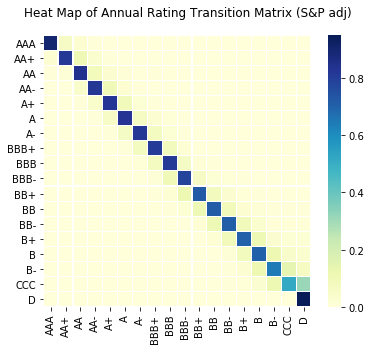

In [7]:
# Annual
# ######################################################################
# params aggregatese
vmins_trg = (val_cmin, val_cneg)
vmaxs_trg = (val_cmax, val_cmin)
# visualize
title = 'Heat Map of Annual Rating Transition Matrix ('+trg_src+')'
heatmap_matrix(df_rtm,vmin=val_cmin,vmax=val_cmax,header=title)


### 2.3. Weekly scaled RTM by 52nd power root

Here is the RTM scaled to weekly basis by taking 52nd power root of the RTM. A table right side shows grids where components are negative numbers.

This problems is so-called **embeddability problem**, and based on ***Inamura (2006)*** the problem may be happening when *there are stats i and j such that j is accessible from i, but $p_{ij}=0$*, where $i$ and $j$ denote ratings.

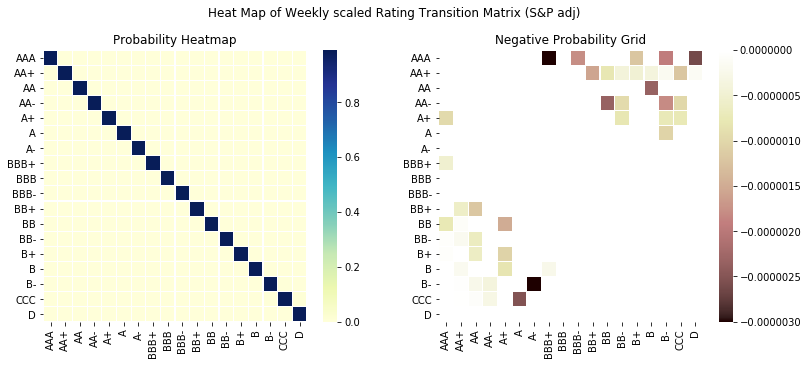

In [8]:
# Weekly
# ######################################################################
r52_rtm = build_rtm_df(lg.fractional_matrix_power(df_rtm,1.0/num_week),lst_rating)

# params aggregatese
vmins_trg = (val_cmin, -3.0e-6)
vmaxs_trg = (0.99, val_cmin)
# visualization
title = 'Heat Map of Weekly scaled Rating Transition Matrix ('+trg_src+')'
multi_heatmap_matrix(r52_rtm,vmins_trg,vmaxs_trg,cmaps_trg,header=title)


### 2.4. Weekly scaled RTM floored at zero vs replication

When taking positive part of the weekly scaled RTM (e.g. floored at zero) and revert back to annual scale by raising to 52nd power, the reverted annula matrix shows minor difference from the original matrix, whose error comes from negative numbers cut off at weekly scale. 

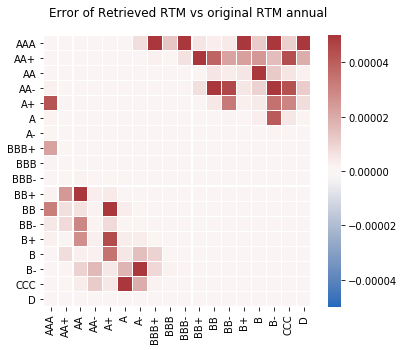

In [9]:
# Floored at zero
# ######################################################################
r52_rtm_floored = np.maximum(r52_rtm,0.0)
rtm_recovered = build_rtm_df(lg.fractional_matrix_power(r52_rtm_floored,num_week),lst_rating)
rtm_error = rtm_recovered-df_rtm

# figure parameters
err_cmax =  5.0e-5
err_cmin = -5.0e-5
# visualize
title = 'Error of Retrieved RTM vs original RTM annual'
heatmap_matrix(rtm_error,vmin=err_cmin,vmax=err_cmax,cmap=cmap_trg3,header=title)


### 2.5. Problem of this approach

The approach taken here should have many problems. For example,

1. The flooring was done at specific time scale (e.g. weekly in the case above), so there is no consistency between different time scale. For example, when taking the same flooring approach for **quarterly scale**, that should not agree with what was recovered to **quarterly scale from floored weekly RTM**.
1. We did not make any adjustment for RTM to offset the impact from flooring, so the floored RTM is actually **NOT RTM to meet the nature of the probability where sum of values of each row must be exactly one**.
1. To take floor at zero does not make any mathematical sense and that **drops information**. Also, if the magnitude of the value cut off by floor would be the larger, the more information will be lost then we will likely see the larger error when recovering the matrix to annual.


### 2.6. Possible approaches

In order to deal with the problems exemplified above,

1. We may deal with this problem by assuming **continuous** time model, rather discrete time model. **Generator** method would be an approach that is suitable to this purpose.
1. We should make some **adjustments** to make the RTMs with any time scale to be transition probability matrixes.
1. We should better to assume that the RTM provided from rating agencies is mathematically **dirty/incomplete**, whilst we assumed that the RTM was perfect information. We may use some **statistical inferences** or **Bayesian approaches** to deal with this point.

***Inamura (2006)*** well summarizes some possible approaches from previous researches. Let's try some of the approaches here.

## 5. Further Approaches

***Inamura (2006)*** compares further three approaches:

- **Quasi-optimization**
- **EM algorithm**
- **MCMC (Marcov Chain Monte Carlo)** (\* make sure not implying Mizuho Capital Markets Corporation, the former entity of MSUSA fixed income division!)

Actually, DA and WA algorithms still do the similar adjusments of flooring at zero as we first made, which does not make any statistical sense (3rd issue). Also not sure how it works when encountering complex numbers. Hope to find a way to deal with it over these approaches above. We did not implement them yet, so it would be a possible next step for the team to start with, whilst it is up to you.

Also, we expect you for the project to:
1. Look for **further modern/sophisticated approaches** if possible in addition to them.
2. Analyze **pros/cons** over approaches by applying **various RTMs** you found.


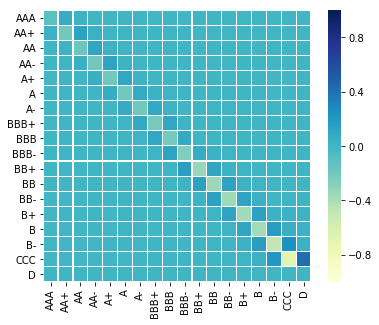

In [10]:
# data feed
gen_m = lg.logm(df_rtm)
df_gen_m = build_rtm_df(gen_m,lst_rating)
heatmap_matrix(df_gen_m,1.0,-1.0)

### 5.3. MCMC Algorithm

In [11]:
def RTM_Chain_org(alpha, beta, N, rands, Q_gen = None):
    deltat = 1/N
    K = len(beta)
    N_tilde = np.zeros((K, K))
    R_tilde = np.zeros(K)
    # step 1: Constructing initial Q
    Q = np.random.gamma(scale = 1/beta, shape = alpha)
    # rescaling the diagonals:
    for i in range(K):
        Q[i, i] = 0.0
        Q[i, i] = -np.sum(Q[i, :])
    # step 1.5: Appointing the data generator
    if Q_gen is None:
        Q_gen = Q.copy()
    # step 2: Simulating markov chain
    Rs = []
    Ns = []
    for _ in range(N):
        for k in range(K):
            q_k = -Q[k, k]
            if q_k == 0.0:
                continue
            S_k = np.random.exponential(scale = q_k, size = 1)
            if S_k < deltat:
                tran_prob = Q_gen[k, :]/q_k
                tran_prob[k] = 0.0 # to skip the probability of staying at the same rating
                rand = rands[k, _]
                try:
                    j = np.arange(K-1)[(tran_prob.cumsum() - rand > 0)][0].astype(int)
                except:
                    j = 0
                N_tilde[k, j] += 1
                R_tilde[k] += S_k
            else:
                continue
        Rs.append(R_tilde)
        Ns.append(N_tilde)
    return (N_tilde + alpha, R_tilde + beta, Q, np.array(Ns), np.array(Rs))

In [12]:
def MCMC_algo_org(alpha_0, beta_0, seed, N, G, Q_gen=None, freq=1000):
    np.random.seed(seed)
    rands_3d = np.random.rand(G + 1, len(beta_0), N)
    alpha_new, beta_new = alpha_0, beta_0
    ret_dict = {'Q_gen': [], 'N_': [], 'R_': []}
    first = True
    iter = 0
    for rands in rands_3d:
        if first:
            first = False
            iter += 1
            continue
        alpha_new, beta_new, Q_new, N_records, R_records = RTM_Chain_org(alpha_new, beta_new, N, rands, Q_gen)
        ret_dict['Q_gen'].append(Q_new)
        ret_dict['N_'].append(N_records)
        ret_dict['R_'].append(R_records)
        
        if iter%freq==0:
            print('Iteration:',str(iter))
        iter += 1
        
    return ret_dict

### Tak revised

In [65]:
def RTM_Chain(alpha, beta, N, rands, Q_gen = None):
    deltat = 1.0/N
    K = len(beta)
    N_tilde = np.zeros((K, K))
    R_tilde = np.zeros(K)
    # step 1: Constructing initial Q
    Q = np.random.gamma(scale = 1/beta, shape = alpha)
    # rescaling the diagonals:
    for i in range(K):
        Q[i, i] = 0.0
        Q[i, i] = -np.sum(Q[i, :])
    # step 1.5: Appointing the data generator
    ### Tak modified ###
    if Q_gen is not None:
        Q = Q_gen.copy()
        print('check Q')
    # step 2: Simulating markov chain
    Rs = []
    Ns = []
    # n-th simulation over N time period
    for _ in range(N):
        for k in range(K):
            q_k = (-1.0)*Q[k, k]
            if q_k == 0.0:
                continue
            # Tak: Sill need  to understand
            S_k = np.random.exponential(scale = q_k, size = 1)
#            S_k = np.random.exponential(scale = 1/q_k, size = 1)
#            S_k = q_k*np.exp(-q_k*deltat)
            if S_k < deltat:
                ### Tak modified ###
                tran_prob = Q[k, :]/q_k
                tran_prob[k] = 0.0 # to skip the probability of staying at the same rating
                rand = rands[k, _]
#                while True:
#                    rand = np.random.rand()
                try:
                    ### Tak: include default ###
#                    j = np.arange(K-1)[(tran_prob.cumsum() - rand > 0)][0].astype(int)
                    j = np.arange(K)[(tran_prob.cumsum() - rand > 0)][0].astype(int)
                    N_tilde[k, j] += 1
                    R_tilde[k] += S_k
#                    print('(n, k, j)',_ ,k ,j)
#                    break
                except:
                    ### Tak modified ###
                    #j = 0
                    #j = k
                    continue
            else:
                continue
                
        Rs.append(R_tilde)
        Ns.append(N_tilde)
        
    ### Tak modified ###
    return (N_tilde, R_tilde, Q, np.array(Ns), np.array(Rs))

In [30]:
def MCMC_algo(alpha_0, beta_0, seed, N, G, Q_gen=None, freq=1000):
    np.random.seed(seed)
    rands_3d = np.random.rand(G + 1, len(beta_0), N)
    alpha_new, beta_new = alpha_0, beta_0
    ### Tak: initialize ###
    ret_dict = {'Q_gen': [], 'N_': [], 'R_': [], 'alpha': [], 'beta': []}
    is_first = True
    iter = 0
    ### Tak: initialize ###
    K = len(beta_0)
    N_tilde = np.zeros((K, K))
    R_tilde = np.zeros(K)
    for rands in rands_3d:
        if is_first:
            is_first = False
            ### Tak modified ###
            N_tilde, R_tilde, Q_new, N_records, R_records = RTM_Chain(alpha_new, beta_new, N, rands, Q_gen)
            alpha_new = alpha_0 + N_tilde
            beta_new = beta_0 + R_tilde
            iter += 1
            continue
#        alpha_new, beta_new, Q_new, N_records, R_records = RTM_Chain(alpha_new, beta_new, N, rands, Q_gen)
        ### Tak revised: Q_new should be input ###
        N_tilde, R_tilde, Q_new, N_records, R_records = RTM_Chain(alpha_new, beta_new, N, rands, None)
        alpha_new = alpha_0 + N_tilde
        beta_new = beta_0 + R_tilde

        ret_dict['Q_gen'].append(Q_new)
        ret_dict['N_'].append(N_tilde)
        ret_dict['R_'].append(R_tilde)
        
        if iter%freq==0:
            print('Iteration:',str(iter))
        iter += 1
        
    return ret_dict

#### 5.3.1. Tuned Prior Approach

In [15]:
# dimention of RTM
dim_rtm = df_rtm.shape[0]
# bureate list to save betas
tuned_betas = []
### Tak: skip last row of default ###
for i in range(dim_rtm-1):
    ### Tak modified: change fit target from df_rtm to df_gem_m ###
    #alpha, loc, beta = gamma.fit(df_rtm.iloc[i, :])
    ### Tak modified: delete (i,i) from the data to fit ###
    trg_dat = list(df_gen_m.iloc[i, :])
    del trg_dat[i]
    arr_dat = np.array(trg_dat)
    alpha, loc, beta = gamma.fit(arr_dat)
    tuned_betas.append(beta)
#    print(alpha)

### Tak added: beta for the last row ###
tuned_betas.append(1.0)

tuned_betas = np.array(tuned_betas)

In [16]:
tuned_betas

array([0.03193108, 0.07411035, 0.04869164, 0.06084074, 0.09393196,
       0.03233444, 0.02531912, 0.0522361 , 0.04093068, 0.06052867,
       0.06149245, 0.04183225, 0.05394981, 0.0576863 , 0.09931156,
       0.1043963 , 0.4070862 , 1.        ])

In [17]:
tuned_alphas = np.zeros((dim_rtm, dim_rtm))
for i in range(dim_rtm-1):
    for j in range(dim_rtm-1):
        ### Tak modified: diagonal should notoverwritten  ###
        if i != j:
#            tuned_alphas[i, j] = df_rtm.iloc[i, j] / tuned_betas[i]
            ### Tak modified: change alpha estimation and the reference ###
#            tuned_alphas[i, j] = df_rtm.iloc[i, j] * tuned_betas[i]
            tuned_alphas[i, j] = df_gen_m.iloc[i, j] * tuned_betas[i]
tuned_alphas = np.maximum(tuned_alphas, 1.0e-12)

In [61]:
tuned_alphas[0]

array([1.00000000e-12, 2.24450026e-03, 7.99193541e-04, 1.74004665e-04,
       2.82673111e-05, 7.75275436e-05, 4.21530616e-05, 1.00000000e-12,
       1.68650384e-05, 1.00000000e-12, 1.05102276e-05, 1.89261373e-05,
       1.08224287e-05, 1.00000000e-12, 1.19215634e-05, 1.00000000e-12,
       2.34995202e-05, 1.00000000e-12])

In [72]:
MCMC_pt_result = MCMC_algo(tuned_alphas, tuned_betas, seed=123, N=100, G=10000, freq=1000)
#MCMC_pt_result = MCMC_algo_org(tuned_alphas, tuned_betas, seed=123, N=100, G=10000, freq=1000)


Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000


In [73]:
Qs = MCMC_pt_result.get('Q_gen')
chgs_Qs = np.array([q2-q1 for q1, q2 in zip(Qs[:-1], Qs[1:])])
abs_chgs_Qs = np.abs(chgs_Qs).mean(axis=1).mean(axis=1)
sr_err_abs = pd.Series(abs_chgs_Qs, index=range(len(abs_chgs_Qs)))


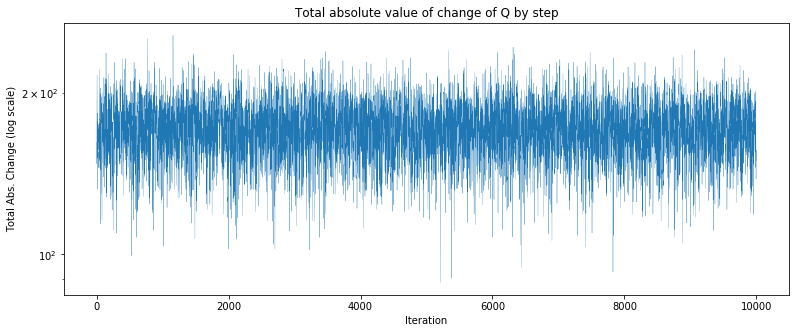

In [74]:
fig, ax = plt.subplots(1,1,figsize=size_figl)
sr_err_abs.plot(ax=ax,lw=0.25)
ax.set_title('Total absolute value of change of Q by step',fontsize=size_fntl)
ax.set_xlabel('Iteration')
ax.set_ylabel('Total Abs. Change (log scale)')
ax.set_yscale('log')
plt.show()


In [75]:
gen_mc_samples = np.array(MCMC_pt_result.get('Q_gen'))
#num_burn_in = 1000
num_burn_in = 0
gen_mc_pt = gen_mc_samples[num_burn_in:].mean(axis=0)

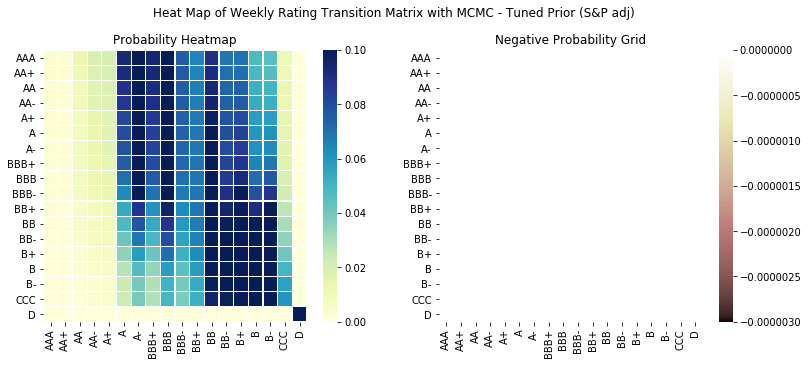

In [79]:
trg_method = 'MCMC - Tuned Prior'
# Weekly scale
t = 1.0/num_week
rtm_weekly = lg.expm(gen_mc_pt*t)
df_rtm_weekly = build_rtm_df(rtm_weekly,lst_rating)
# params aggregatese
vmins_trg = (val_cmin, -3.0e-6)
vmaxs_trg = (1.0e-1, val_cmin)
# visualization
title = 'Heat Map of Weekly Rating Transition Matrix with '+trg_method+' ('+trg_src+')'
multi_heatmap_matrix(df_rtm_weekly,vmins_trg,vmaxs_trg,cmaps_trg,header=title)
None

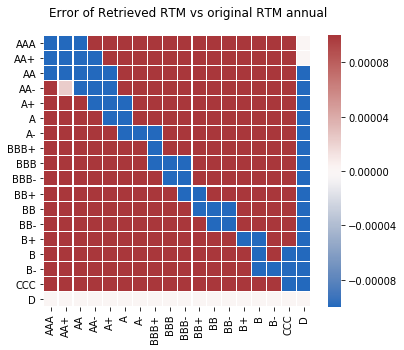

In [77]:
# validation
df_rtm_recovered = build_rtm_df(lg.expm(gen_mc_pt*1.0),lst_rating)
rtm_error = df_rtm_recovered-df_rtm
# figure parameters
err_cmax =  1.0e-4
err_cmin = -1.0e-4
# visualize
title = 'Error of Retrieved RTM vs original RTM annual'
heatmap_matrix(rtm_error,vmin=err_cmin,vmax=err_cmax,cmap=cmap_trg3,header=title)
None

In [78]:
Ns = MCMC_pt_result.get('N_')
Ns_sum = [x.sum() for x in Ns]
np.mean(Ns_sum)

761.456

#### 5.3.2. External Generator

In [80]:
weak_alphas = np.zeros((18, 18))
weak_betas = np.ones(18)


In [81]:
gen_m_adj = np.maximum(gen_m,0.0)
for k in range(dim_rtm):
    gen_m_adj[k,k] = (-1.0) * np.sum(gen_m_adj[k,:])

In [82]:
MCMC_exG_result = MCMC_algo(tuned_alphas, tuned_betas, seed=123, N=100, G=10000, freq=1000, Q_gen=gen_m_adj)


check Q
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000


In [83]:
alphas = MCMC_exG_result.get('alpha')
betas = MCMC_exG_result.get('beta')


In [84]:
betas

[]

In [85]:
Qs = MCMC_exG_result.get('Q_gen')
chgs_Qs = np.array([q2-q1 for q1, q2 in zip(Qs[:-1], Qs[1:])])
abs_chgs_Qs = np.abs(chgs_Qs).mean(axis=1).mean(axis=1)
sr_err_abs = pd.Series(abs_chgs_Qs, index=range(len(abs_chgs_Qs)))


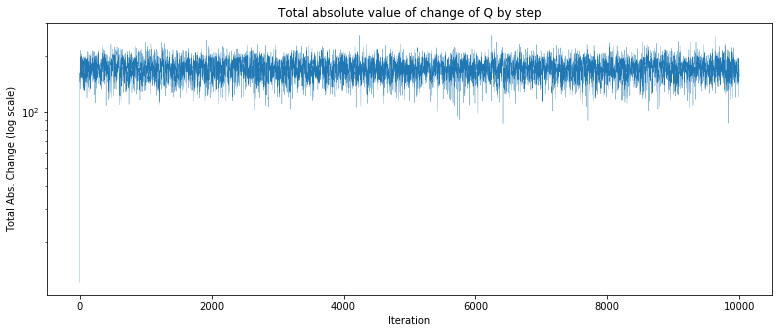

In [86]:
fig, ax = plt.subplots(1,1,figsize=size_figl)
sr_err_abs.plot(ax=ax,lw=0.25)
ax.set_title('Total absolute value of change of Q by step',fontsize=size_fntl)
ax.set_xlabel('Iteration')
ax.set_ylabel('Total Abs. Change (log scale)')
ax.set_yscale('log')
plt.show()


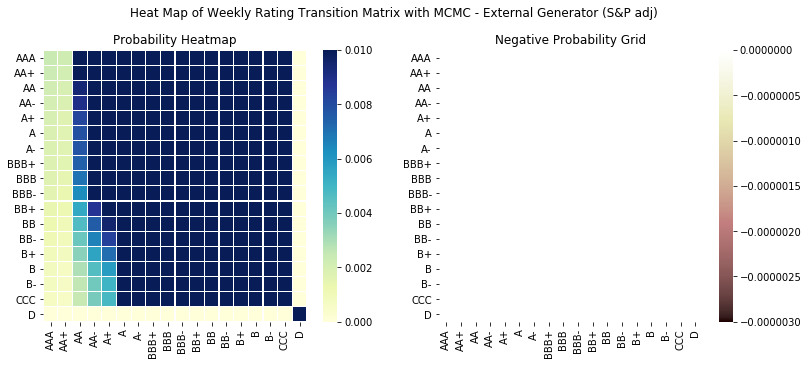

In [87]:
trg_method = 'MCMC - External Generator'
gen_mc_exG = np.mean(MCMC_exG_result.get('Q_gen'), axis = 0)

# Weekly scale
t = 1.0/num_week
rtm_weekly = lg.expm(gen_mc_exG*t)
df_rtm_weekly = build_rtm_df(rtm_weekly,lst_rating)
# params aggregatese
vmins_trg = (val_cmin, -3.0e-6)
vmaxs_trg = (0.01, val_cmin)
# visualization
title = 'Heat Map of Weekly Rating Transition Matrix with '+trg_method+' ('+trg_src+')'
multi_heatmap_matrix(df_rtm_weekly,vmins_trg,vmaxs_trg,cmaps_trg,header=title)
None

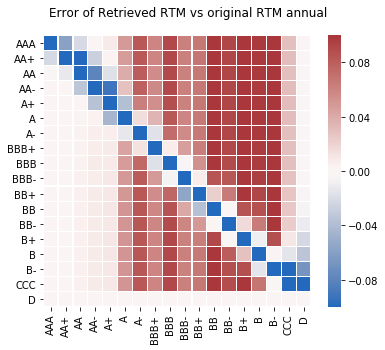

In [88]:
# validation
df_rtm_recovered = build_rtm_df(lg.expm(gen_mc_exG*1.0),lst_rating)
rtm_error = df_rtm_recovered-df_rtm
# figure parameters
err_cmax =  1.0e-1
err_cmin = -1.0e-1
# visualize
title = 'Error of Retrieved RTM vs original RTM annual'
heatmap_matrix(rtm_error,vmin=err_cmin,vmax=err_cmax,cmap=cmap_trg3,header=title)
None